Script to analyze the results on real datasets. This includes plotting the trees, gene expression analysis, examining optimized parameters and mutations.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pygraphviz as pgv
import seaborn as sns
import os
import json
import sys
from pathlib import Path
from collections import Counter
from dendropy import Tree, TreeList, TaxonNamespace

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import dendropy
from dendropy.calculate import treecompare

from src_python.utils import path_len_dist
from src_python.cell_tree import CellTree

In [2]:
study_nums = ["mm16", "mm34"] # cancer sample ids to analyze
np.random.seed(0)
n_rounds = 2 # Number of rounds of parameter and tree optimization
use_summary_statistics = True # If True uses summary files instead of raw data files

primary_cells = {}
cell_names = {}
expression_counts_scaled = {}

for study_num in study_nums: # Primary tumor cells
    if study_num == "mm34":
        cell_indices = ["SRR6710302", "SRR6710303", "SRR6710304", "SRR6710305", "SRR6710306", "SRR6710307", "SRR6710308", "SRR6710309", "SRR6710310", "SRR6710311", "SRR6710312", "SRR6710313", "SRR6710314", "SRR6710315", "SRR6710316", "SRR6710317", "SRR6710318", "SRR6710319", "SRR6710320", "SRR6710321", "SRR6710322", "SRR6710323", "SRR6710324", "SRR6710325", "SRR6710326", "SRR6710327", "SRR6710328", "SRR6710329", "SRR6710330", "SRR6710331", "SRR6710332", "SRR6710333", "SRR6710334", "SRR6710335", "SRR6710336", "SRR6710337", "SRR6710338", "SRR6710339", "SRR6710340", "SRR6710341", "SRR6710342", "SRR6710343", "SRR6710344", "SRR6710345", "SRR6710346", "SRR6710347", "SRR6710348", "SRR6710349", "SRR6710350", "SRR6710351", "SRR6710352", "SRR6710353", "SRR6710354", "SRR6710355", "SRR6710356", "SRR6710357", "SRR6710358", "SRR6710359", "SRR6710360", "SRR6710361", "SRR6710362", "SRR6710363", "SRR6710364", "SRR6710365", "SRR6710366"]

    if study_num == "mm16":
        cell_indices = ["SRR6710256", "SRR6710257", "SRR6710258", "SRR6710259", "SRR6710260", "SRR6710261", "SRR6710262", "SRR6710263", "SRR6710264", "SRR6710265", "SRR6710266", "SRR6710267", "SRR6710268", "SRR6710269", "SRR6710270", "SRR6710271", "SRR6710272", "SRR6710273", "SRR6710274", "SRR6710275", "SRR6710276", "SRR6710277", "SRR6710278"]

    ref = np.array(pd.read_csv(os.path.join(f"../data/input_data/{study_num}", "ref.csv")))
    cell_names[study_num] = list(ref[:,0])
    primary_cells[study_num] = [cell_names[study_num].index(item) for item in cell_indices if item in cell_names[study_num]]

    expression_counts = pd.read_csv(rf"../data/input_data/{study_num}/gene_expression_counts.csv", index_col=0)
    normalized_counts = expression_counts.div(expression_counts.sum(axis=1), axis=0) * 1e5
    expression_counts_scaled[study_num] = np.log1p(normalized_counts)

Plot the trees

In [3]:
def plot_trees(inpath, test, plot_mutations=False, round=0, pc=[], model="", cell_ids=[]):

    path_parent = os.path.join(inpath, f"{model}_parent_vec", f"{model}_parent_vec{round}{test}.txt")
    path_mut_loc = os.path.join(inpath, f"{model}_mutation_location", f"{model}_mutation_location{round}{test}.txt")
    path_selected = os.path.join(inpath, f"{model}_selected_loci", f"{model}_selected_loci{round}{test}.txt")

    parent_vec = np.loadtxt(path_parent, dtype=int)
    if os.path.exists(path_mut_loc) == False:
        mut_locs = []
        selected_mutations = []
    else:
        mut_locs = np.loadtxt(path_mut_loc, dtype=int)
        selected_mutations = np.loadtxt(path_selected, dtype=int)

    n_cells = int(((len(parent_vec)+1)/2))

    ct = CellTree(n_cells=n_cells, n_mut=len(selected_mutations))
    ct.use_parent_vec(parent_vec)

    if plot_mutations:
        ct.mut_loc = mut_locs
        graph = ct.to_graphviz()
        graph.render(os.path.join(inpath, f"{model}_ct_trees", f"ct_tree{round}{test}"), format="png", cleanup=True)

    ct.mut_loc = []
    graph_branches = ct.to_graphviz()
    for n in range(n_cells):
        if n in pc:
            graph_branches.node(str(n), label=cell_ids[n], shape="circle", style="filled", color="red")
        else:
            graph_branches.node(str(n), label=cell_ids[n], shape="circle", style="filled", color="blue")

    graph_branches.render(os.path.join(inpath, f"{model}_ct_trees", f"ct_tree{round}{test}_branches"), format="svg", cleanup=True)

for study_num in study_nums:
    path = rf"../data/results/{study_num}/sciterna"
    for j in range(2):
        plot_trees(path, "r0", plot_mutations=True, round=f"_{j}", pc = primary_cells[study_num], model="sciterna", cell_ids=cell_names[study_num])

    model = "sclineager"
    plot_trees(rf"../data/results/{study_num}/sclineager", "", plot_mutations=False, round = "", pc = primary_cells[study_num], model="sclineager", cell_ids=cell_names[study_num])
    plot_trees(rf"../data/results/{study_num}/dendro", "", plot_mutations=False, round = "", pc = primary_cells[study_num], model="dendro", cell_ids=cell_names[study_num])
    plot_trees(rf"../data/results/{study_num}/phylinsic", "", plot_mutations=False, round = "", pc = primary_cells[study_num], model="phylinsic", cell_ids=cell_names[study_num])

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.858112 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.436707 to fit


In [4]:
def plot_consensus_tree(parent_vector, path, study_num, support_thresholds=None, cell_ids=[]):

    n_cells = int((len(parent_vector) + 1) / 2)
    ct = CellTree(n_cells=n_cells, n_mut=0)
    ct.use_parent_vec(parent_vector)
    ct.mut_loc = []

    graph_branches = ct.to_graphviz()

    for node_id in range(len(parent_vector)):
        is_leaf = node_id < n_cells
        node_shape = "circle"
        node_style = "filled"

        if is_leaf:
            border_color = "red" if node_id in primary_cells[study_num] else "blue"
            fillcolor = "red" if node_id in primary_cells[study_num] else "blue"

            graph_branches.node(
                str(node_id),
                label= cell_ids[node_id],
                shape=node_shape,
                style=node_style,
                fillcolor=fillcolor,
                color=border_color,
                penwidth="4"
            )
        else:
            fillcolor = "lightgrey"
            penwidth = 1

            max_support = np.max(list(support_thresholds.values()))
            if support_thresholds:
                support = support_thresholds.get(str(node_id), 0.0)

                penwidth = 20 * support/max_support

            graph_branches.node(
                str(node_id),
                shape=node_shape,
                style=node_style,
                fillcolor=fillcolor,
                color="black",
                penwidth=str(penwidth)
            )

    else:
        graph_branches.render(os.path.join(path, f"sciterna_consensus_tree_{study_num}"), format="svg", cleanup=True)
    return graph_branches

graphs = {}
consensus_parent_vec = {}
for study_num in study_nums:
    path_bootstrap = rf"../data/results/{study_num}/sciterna_bootstrap"
    consensus_parent_vec[study_num] = np.loadtxt(os.path.join(path_bootstrap, "sciterna_consensus_parent_vec","sciterna_parent_vec_1r.txt"), dtype=int)

    with open(os.path.join(path_bootstrap, "sciterna_consensus_parent_vec", "sciterna_support_values_1r.json"), "r") as f:
        support_values = json.load(f)

    graph = plot_consensus_tree(consensus_parent_vec[study_num], path_bootstrap, study_num, support_thresholds=support_values, cell_ids=cell_names[study_num])
    graphs[study_num] = graph

In [5]:
def get_node_positions(dot):
    """Get x-coordinates of all nodes from Graphviz layout."""
    A = pgv.AGraph(string=dot.source if hasattr(dot, 'source') else dot)
    A.layout(prog="dot")
    positions = {}
    for node in A.nodes():
        name = node.get_name()
        if not name.isdigit():
            continue
        pos = node.attr.get('pos')
        if pos:
            x = float(pos.split(',')[0])
            positions[int(name)] = x
    return positions

def dfs_left_to_right(graph, root, n_cells, positions):

    leaf_order = []

    def dfs(node):
        children = graph.get(node, [])
        # Sort children by x-position
        children_sorted = sorted(children, key=lambda x: positions.get(x, float("inf")))
        if not children:
            if node < n_cells:  # leaf node condition
                leaf_order.append(node)
            return
        for child in children_sorted:
            dfs(child)

    dfs(root)
    return leaf_order

# Build adjacency list from parent vector
def build_adj_list(parent_vec):
    from collections import defaultdict
    adj = defaultdict(list)
    for child, parent in enumerate(parent_vec):
        if parent != -1:
            adj[parent].append(child)
    return adj

leaf_orders = {}
for study_num in study_nums:
    positions = get_node_positions(graphs[study_num])
    adj_list = build_adj_list(consensus_parent_vec[study_num])
    root = np.where(np.array(consensus_parent_vec[study_num]) == -1)[0][0]

    leaf_orders[study_num] = dfs_left_to_right(adj_list, root, len(cell_names[study_num]), positions)

Gene expression analysis

<Figure size 4000x2000 with 0 Axes>

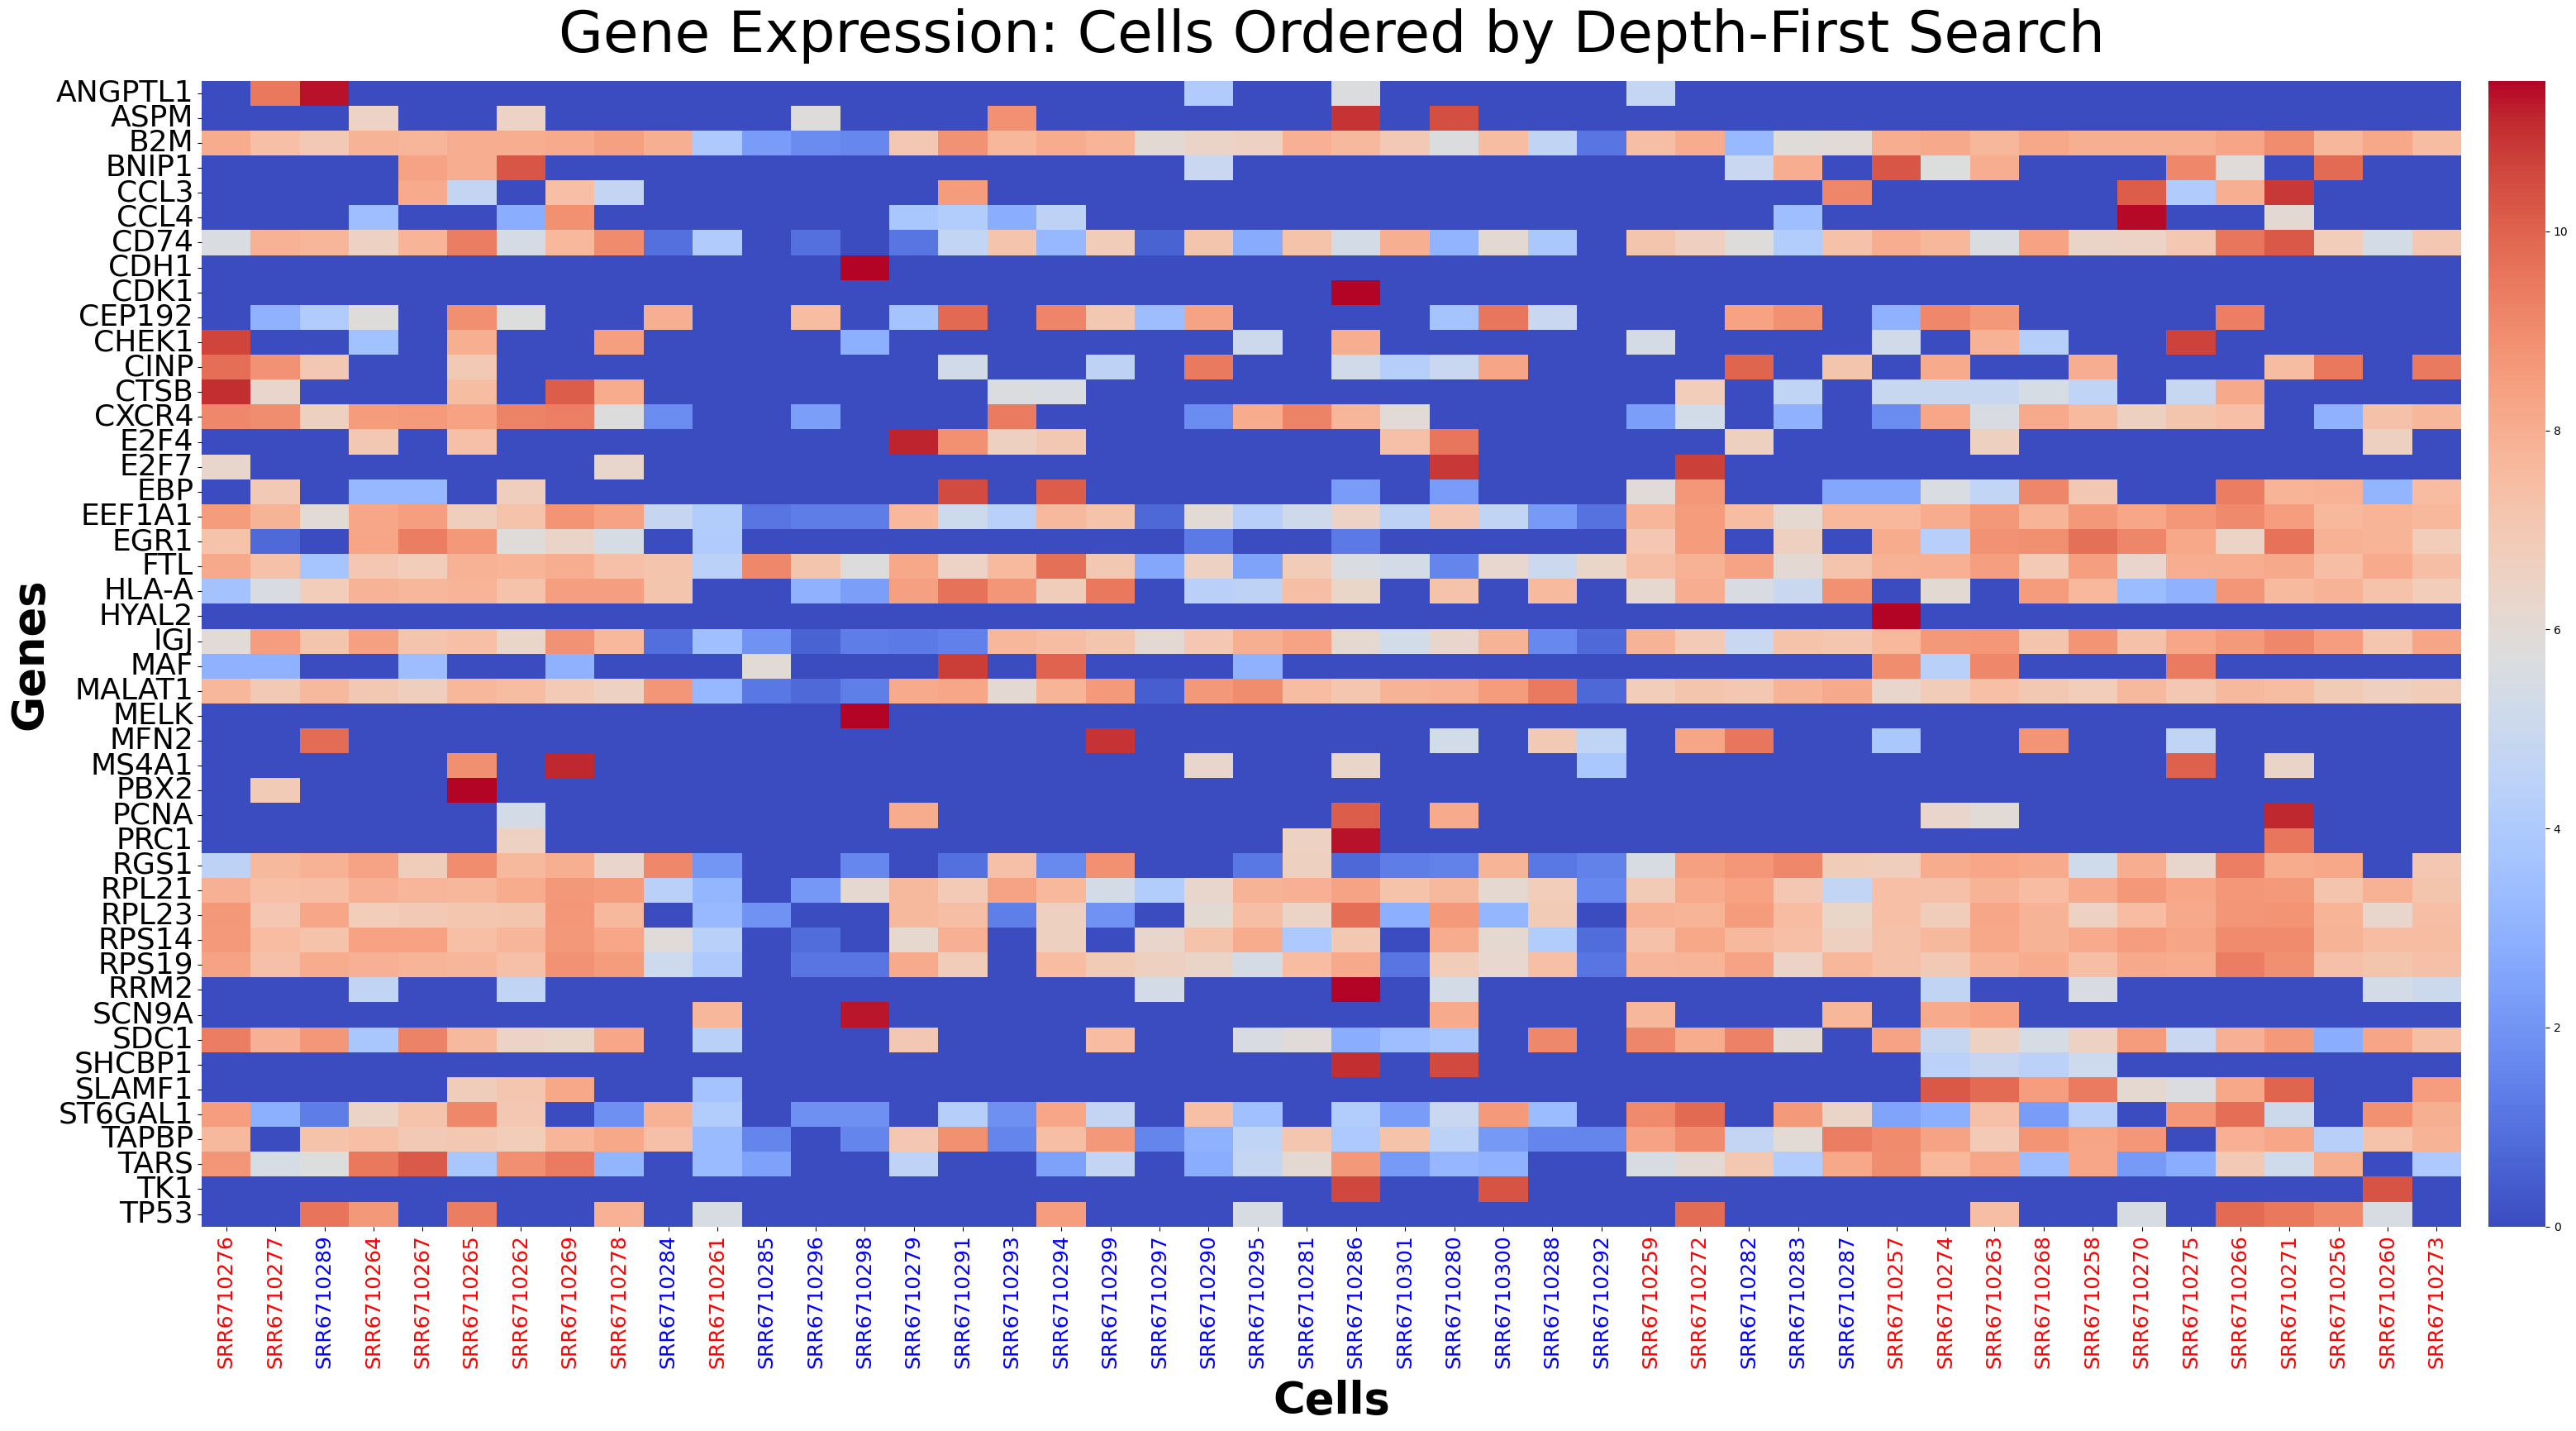

<Figure size 4000x2000 with 0 Axes>

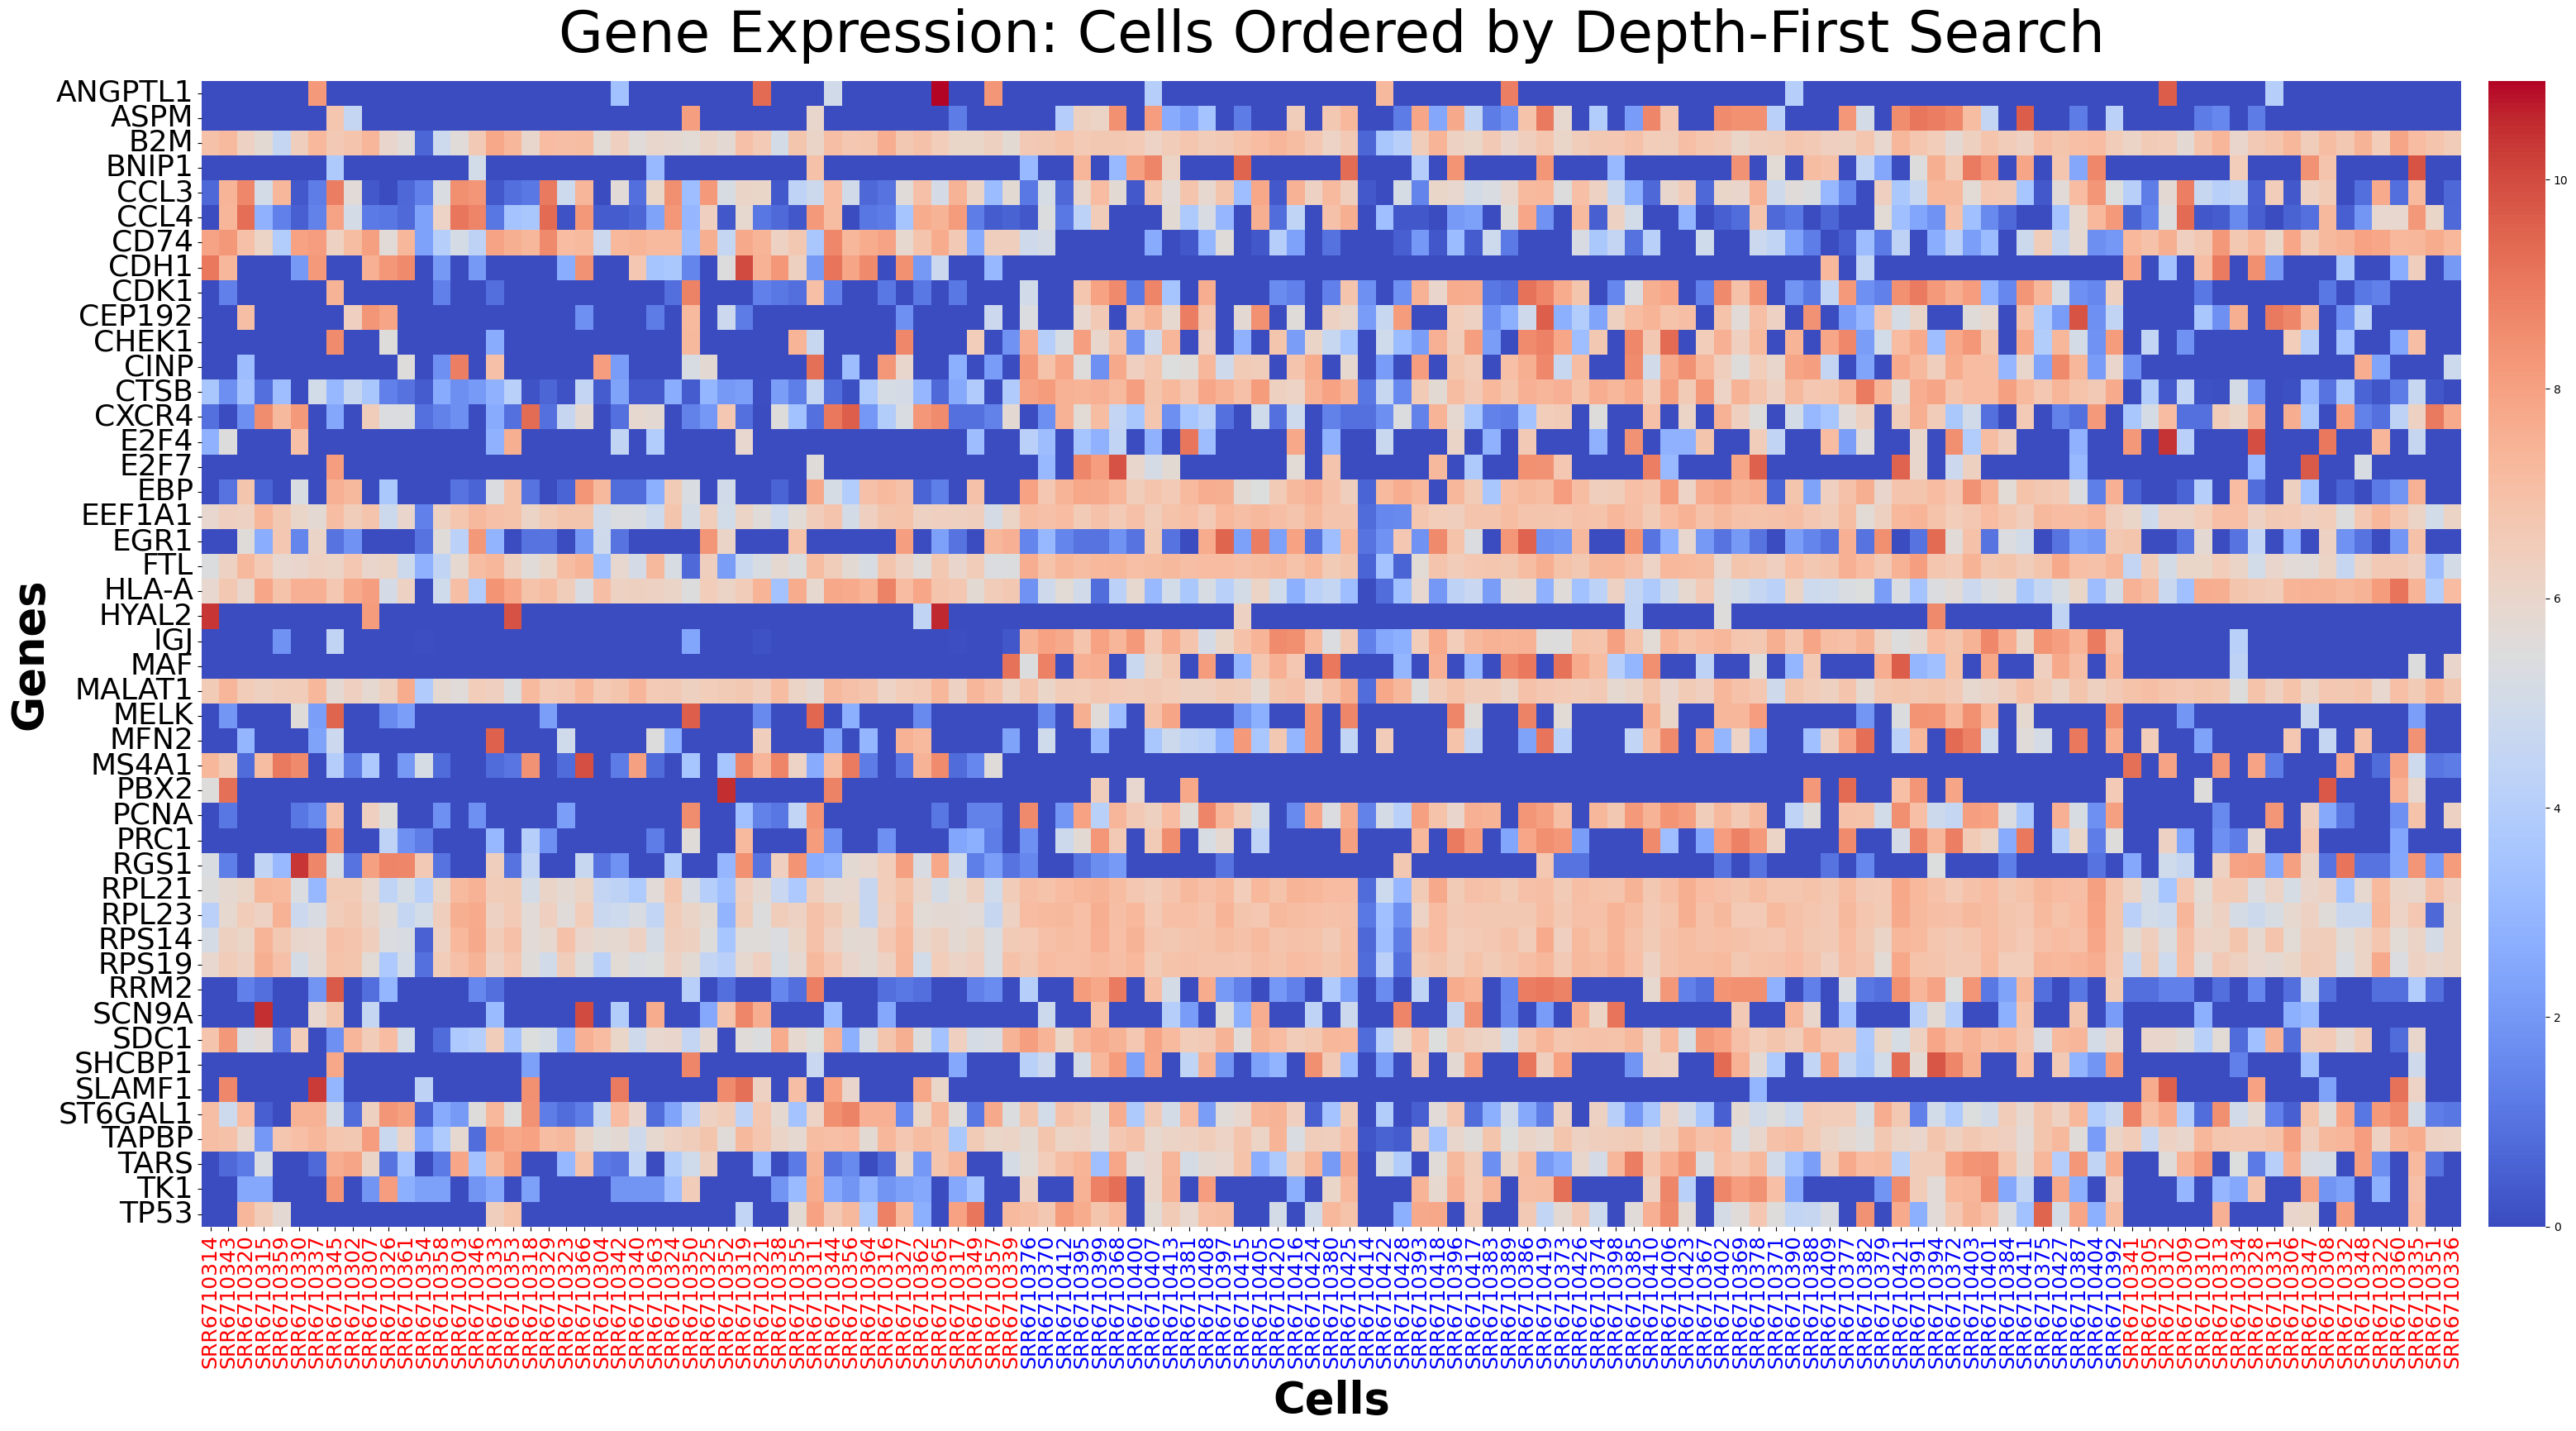

In [6]:
for study_num in study_nums:
    sorted_indices = leaf_orders[study_num]

    plt.figure(figsize=(40, 20))

    genes = ["IGJ", "CTSB", "EGR1", "FTL", "MALAT1", "RPL21", "SDC1", "SLAMF1", "CDH1", "ETV7", "CXCR4", "E2F4", "ANGPTL1", "HYAL2", "PBX2", "SCN9A", "BNIP1", "MFN2", "CEP192", "TARS", "E2F7", "MELK", "CHEK1", "EBP", "CINP", "PCNA", "ASPM", "CDK1", "MAF", "TP53", "MS4A1", "RGS1", "ST6GAL1", "HLA-A", "TAPBP", "CD74", "B2M", "CCL3", "CCL4", "RPS14","RPS19", "RPL23", "EEF1A1", "TK1", "RRM2","SHCBP1", "PRC1"]

    exp = expression_counts_scaled[study_num]
    chosen_genes = exp[exp.index.isin(genes)]
    sorted_df = chosen_genes.iloc[:, sorted_indices]

    col_colors = ["red" if val in primary_cells[study_num] else "blue" for val in sorted_indices]

    plt.figure(figsize=(42, 18))
    ax = sns.heatmap(sorted_df, cmap="coolwarm", cbar_kws={"pad": 0.01})

    for n, tick_label in enumerate(ax.get_xticklabels()):
        tick_label.set_color(col_colors[n])
        tick_label.set_fontsize(18)

    for tick_label in ax.get_yticklabels():
        tick_label.set_fontsize(26)
        tick_label.set_rotation(0)

    plt.title("Gene Expression: Cells Ordered by Depth-First Search", fontsize=50, pad=25)
    plt.ylabel("Genes", fontsize=38, fontweight="bold")
    plt.xlabel("Cells", fontsize=38, fontweight="bold", labelpad=10)
    plt.savefig(rf"../data/results/figures/gene_expression_{study_num}.svg", format="svg")
    plt.show()

Estimating the model parameters

In [7]:
n_bootstrap = 1000

global_parameters = {}
mean_individual_overdispersions_h = {}
mean_individual_dropouts = {}

if not use_summary_statistics:
    for study_num in study_nums:
        path_bootstrap = rf"../data/results/{study_num}/sciterna_bootstrap"
        global_parameters[study_num] = []
        for i in range(n_bootstrap):
            for j in range(n_rounds-1, n_rounds):
                global_param = np.loadtxt(os.path.join(path_bootstrap, "sciterna_global_parameters", f"sciterna_global_parameters_{j}r{i}.txt")).tolist()
                global_parameters[study_num].append(global_param)
        global_parameters[study_num] = global_parameters[study_num] # Dropout, Overdispersion homozygous, Error Rate, Overdispersion heterozygous

        selected = np.loadtxt(os.path.join(path_bootstrap, "selected.txt"), delimiter=",", dtype=int)
        ref = pd.read_csv(os.path.join(f"../data/input_data/{study_num}", "ref.csv"))

        all_individual_overdispersions_h = np.full((n_bootstrap, ref.shape[1]), np.nan)
        all_individual_dropouts = np.full((n_bootstrap, ref.shape[1]), np.nan)

        for i in range(n_bootstrap):
            for j in range(n_rounds-1, n_rounds):
                selected_mutations = np.loadtxt(os.path.join(path_bootstrap, "sciterna_selected_loci", f"sciterna_selected_loci_{j}r{i}.txt"), dtype=int)
                individual_dropouts = np.loadtxt(os.path.join(path_bootstrap, "sciterna_individual_dropout_probs", f"sciterna_individual_dropout_probs_{j}r{i}.txt"))
                individual_overdispersions_h = np.loadtxt(os.path.join(path_bootstrap, "sciterna_individual_overdispersions_h", f"sciterna_individual_overdispersions_h_{j}r{i}.txt"))

                unique_mutations = np.unique(selected_mutations)
                for mut in unique_mutations:
                    indices = np.where(selected_mutations == mut)[0]
                    mean_dropout = np.mean(individual_dropouts[indices])
                    mean_overdispersion = np.mean(individual_overdispersions_h[indices])

                    all_individual_dropouts[i, mut] = mean_dropout
                    all_individual_overdispersions_h[i, mut] = mean_overdispersion

        global_parameters_sample = np.array(global_parameters[study_num])

        sufficient_data_columns_od = ~np.any(
            all_individual_overdispersions_h == global_parameters_sample[:, 3][:, np.newaxis], axis=0
        )

        sufficient_data_columns_dropout = ~np.any(
            all_individual_dropouts == global_parameters_sample[:, 0][:, np.newaxis], axis=0
        )
        mean_individual_overdispersions_h[study_num] = np.nanmean(all_individual_overdispersions_h[:, sufficient_data_columns_od], axis=0).tolist()
        mean_individual_dropouts[study_num] = np.nanmean(all_individual_dropouts[:, sufficient_data_columns_dropout], axis=0).tolist()

else:
    with open("../data_summary/real_data/global_parameters.json", "r") as f:
        global_parameters = json.load(f)
    with open("../data_summary/real_data/mean_individual_overdispersions_h.json", "r") as f:
        mean_individual_overdispersions_h = json.load(f)
    with open("../data_summary/real_data/mean_individual_dropouts.json", "r") as f:
        mean_individual_dropouts = json.load(f)

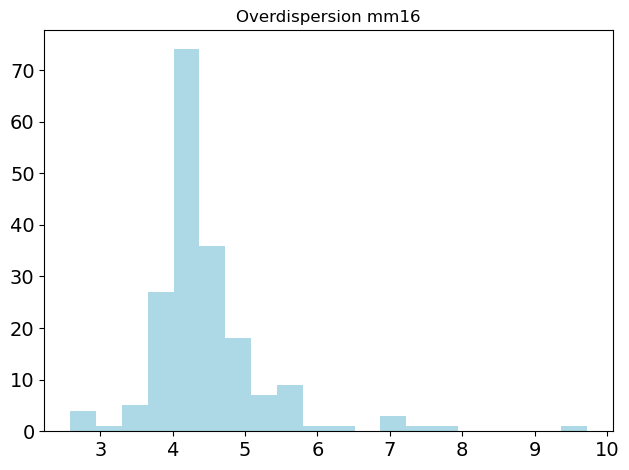

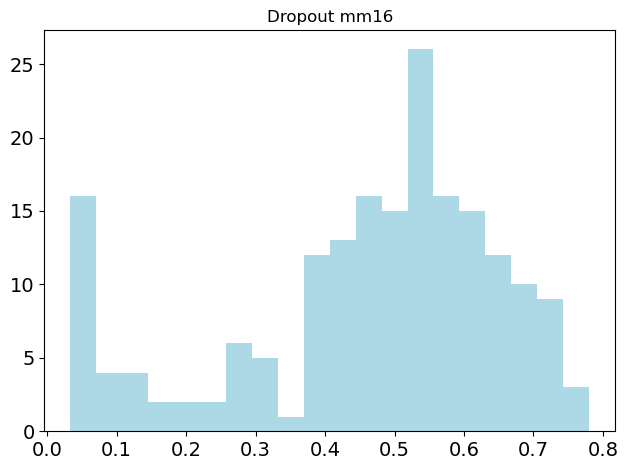

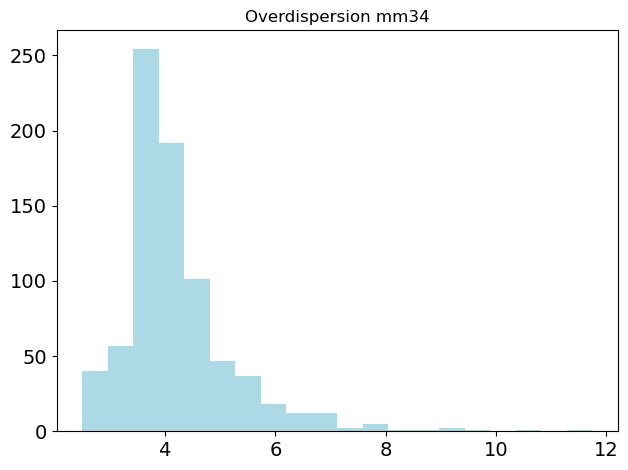

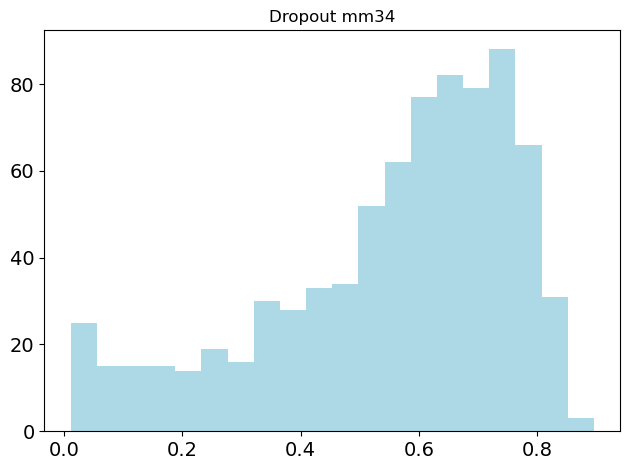

In [8]:
study_nums = ["mm16", "mm34"]
for study_num in study_nums:
    # get the individual parameters, that were optimized for each SNV, instead of using the global parameter value
    mean_dropouts = mean_individual_dropouts[study_num]
    mean_overdispersions = mean_individual_overdispersions_h[study_num]
    path_bootstrap = rf"../data/results/{study_num}/sciterna_bootstrap"

    plt.hist(mean_overdispersions, bins=20, color="lightblue")
    plt.grid(False)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(f"Overdispersion {study_num}")
    plt.tight_layout()
    # plt.savefig(os.path.join(path_bootstrap, "overdispersion_histogram.svg"), format="svg")
    plt.show()

    plt.hist(mean_dropouts, bins=20, color="lightblue")
    plt.grid(False)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(f"Dropout {study_num}")
    plt.tight_layout()
    # plt.savefig(os.path.join(path_bootstrap, "dropout_histogram.svg"), format="svg")
    plt.show()

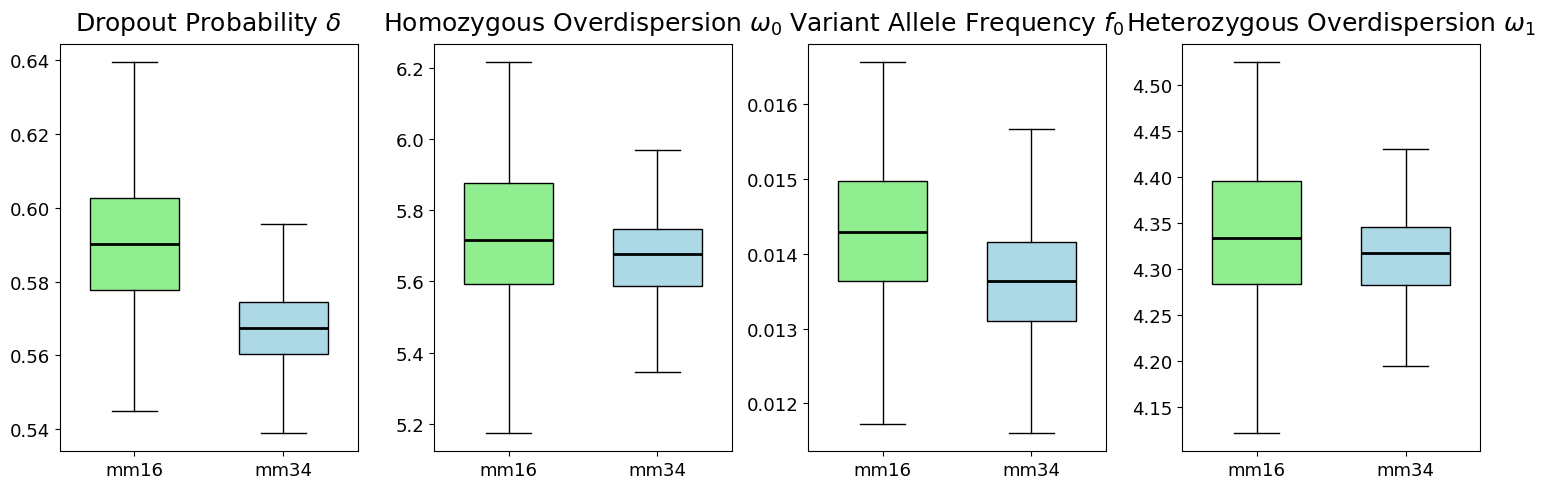

In [9]:
param_names = [r"Dropout Probability $\delta$", r"Homozygous Overdispersion $\omega_\mathrm{0}$", r"Variant Allele Frequency $f_\mathrm{0}$", r"Heterozygous Overdispersion $\omega_\mathrm{1}$"]

for study_num in study_nums:
    global_parameters[study_num] = np.array(global_parameters[study_num])

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
box_colors = ["lightgreen", "lightblue", "lightcoral", "khaki"]

for idx, param_name in enumerate(param_names):
    data = [global_parameters[s][:, idx] for s in study_nums]
    bplot = axes[idx].boxplot(data, patch_artist=True, labels=study_nums, showfliers=False, widths=0.6)

    for patch, color in zip(bplot["boxes"], box_colors):
        patch.set_facecolor(color)
        patch.set_edgecolor("black")

    for median in bplot["medians"]:
        median.set_color("black")
        median.set_linewidth(2)

    axes[idx].set_title(param_name, fontsize=18, pad=10)
    axes[idx].set_ylabel(f"", fontsize=14)
    axes[idx].tick_params(axis="x", labelsize=13)
    axes[idx].tick_params(axis="y", labelsize=13)
    axes[idx].grid(False)

plt.tight_layout()
# plt.savefig(r"..\data\results\figures\global_parameters.pdf", format="pdf")
plt.show()

In [10]:
# GLIOBLASTOMA DATASET
study_num = "BT_S2"
path= rf"../data/results/{study_num}"

path_cell_types = rf"..\data\input_data\{study_num}\SraRunTable_BT_S2.csv"
cell_types = pd.read_csv(path_cell_types)
cell_names = pd.read_csv(rf"..\data\input_data\{study_num}/ref.csv")["Cell"]

run_names = cell_types["Run"].astype(str).tolist()

run_to_type = {}
df_map = cell_types.set_index(cell_types["Run"].astype(str))["cell_type"].to_dict()
for i, run in enumerate(run_names):
    run_to_type[str(run)] = df_map.get(str(run), "unknown")

unique_types = sorted(set(run_to_type.values()))
colors = ["orange", "red", "blue", "green", "purple", "brown", "pink", "gray", "olive", "cyan"]
type_to_color = {t: colors[i] for i, t in enumerate(unique_types)}

In [11]:
np.unique(cell_types["tissue"], return_counts=True)

(array(['Periphery', 'Tumor'], dtype=object), array([446, 723], dtype=int64))

In [12]:
def plot_trees(inpath, test, round="", model="", plot_mutations=False, cell_names=None):
    Model = model # + "_ref_plus_one"
    path_parent = os.path.join(inpath, Model, f"{model}_parent_vec", f"{model}_parent_vec{round}{test}.txt")
    path_mut_loc = os.path.join(inpath, Model, f"{model}_mutation_location", f"{model}_mutation_location{round}{test}.txt")
    path_selected = os.path.join(inpath, Model, f"{model}_selected_loci", f"{model}_selected_loci{round}{test}.txt")

    parent_vec = np.loadtxt(path_parent, dtype=int)
    if os.path.exists(path_mut_loc) == False:
        mut_locs = []
        selected_mutations = []
    else:
        mut_locs = np.loadtxt(path_mut_loc, dtype=int)
        selected_mutations = np.loadtxt(path_selected, dtype=int)

    n_cells = int(((len(parent_vec)+1)/2))

    ct = CellTree(n_cells=n_cells, n_mut=len(selected_mutations))
    ct.use_parent_vec(parent_vec)

    if plot_mutations:
        ct.mut_loc = mut_locs
        graph = ct.to_graphviz()

        for n, run_name in enumerate(cell_names):
            ctype = run_to_type.get(run_name, "unknown")
            fillcolor = type_to_color.get(ctype, "#c0c0c0")
            graph.node(str(n), shape="circle", style="filled", fillcolor=fillcolor, color="black")
            graph.node(str(n), label=run_name)

        graph.render(os.path.join(inpath, Model, f"{model}_ct_trees", f"ct_tree{round}{test}"), format="png", cleanup=True)

    ct.mut_loc = []
    graph_branches = ct.to_graphviz()
    for n, run_name in enumerate(cell_names):
        ctype = run_to_type.get(run_name, "unknown")
        fillcolor = type_to_color.get(ctype, "#c0c0c0")
        graph_branches.node(str(n), shape="circle", style="filled", fillcolor=fillcolor, color=fillcolor)
        graph_branches.node(str(n), label=run_name)

    graph_branches.render(os.path.join(inpath, Model, f"{model}_ct_trees", f"ct_tree{round}{test}_branches_loc"), format="svg", cleanup=True)
    return graph_branches, parent_vec, ct

graph, parent_vector, ct_sciterna = plot_trees(path, test="0", round="_1r", model="sciterna", cell_names=cell_names, plot_mutations=False)
# g, p, c = plot_trees(path, test="", round="", model="phylinsic", cell_names=cell_names, plot_mutations=False)
# g, p, c = plot_trees(path, test="", round="", model="dendro", cell_names=cell_names, plot_mutations=False)
# g, p, c = plot_trees(path, test="", round="", model="sclineager", cell_names=cell_names, plot_mutations=False)

In [13]:
tumor_cells = [run_to_type.get(cell_names[c]) for c in ct_sciterna.dfs(1704) if ct_sciterna.isleaf(c)]
total_tumor_branch = np.sum([1 if t=="Neoplastic"  else 0 for t in tumor_cells])
total_healthy_branch = np.sum([1 if t!="Neoplastic" else 0 for t in tumor_cells])
purity_tumor = total_tumor_branch/len(tumor_cells)

print("Purity tumor:", np.sum([1 if t=="Neoplastic"  else 0 for t in tumor_cells])/len(tumor_cells), "Tumor cells:", total_tumor_branch, "Healthy cells:", total_healthy_branch)

Purity tumor: 0.9282786885245902 Tumor cells: 453 Healthy cells: 35


In [14]:
tumor_indices = [c for c in ct_sciterna.dfs(1704) if ct_sciterna.isleaf(c)]
non_tumor_indices = [c for c in range(len(cell_names)) if c not in tumor_indices]
non_tumor_cells = [run_to_type.get(cell_names[c]) for c in non_tumor_indices]

purity_non_tumor = np.sum([t == "Neoplastic" for t in non_tumor_cells]) / len(non_tumor_cells)
total_tumor_rest = np.sum([t == "Neoplastic" for t in non_tumor_cells])
total_healthy_rest = np.sum([t != "Neoplastic" for t in non_tumor_cells])
print("Purity non-tumor branch:", purity_non_tumor, "Tumor cells:", total_tumor_rest, "Healthy cells:", total_healthy_rest)
print("Fraction of tumor cells in branch:", total_tumor_branch/(total_tumor_branch+total_tumor_rest))
print("Fraction of healthy cells in rest:", total_healthy_rest/(total_healthy_rest+total_healthy_branch))
print("Purity of healthy cells in rest:", total_healthy_rest/(total_healthy_rest+total_tumor_rest))

Purity non-tumor branch: 0.1145374449339207 Tumor cells: 78 Healthy cells: 603
Fraction of tumor cells in branch: 0.8531073446327684
Fraction of healthy cells in rest: 0.945141065830721
Purity of healthy cells in rest: 0.8854625550660793


C:\Users\Norio\AppData\Local\Temp\ipykernel_28724\2347186271.py:16: RuntimeWarning: invalid value encountered in divide
  vaf = np.where((ref + alt) == 0, np.nan, alt / (ref + alt))
C:\Users\Norio\AppData\Local\Temp\ipykernel_28724\2347186271.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("YlOrRd").copy()
C:\Users\Norio\AppData\Local\Temp\ipykernel_28724\2347186271.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


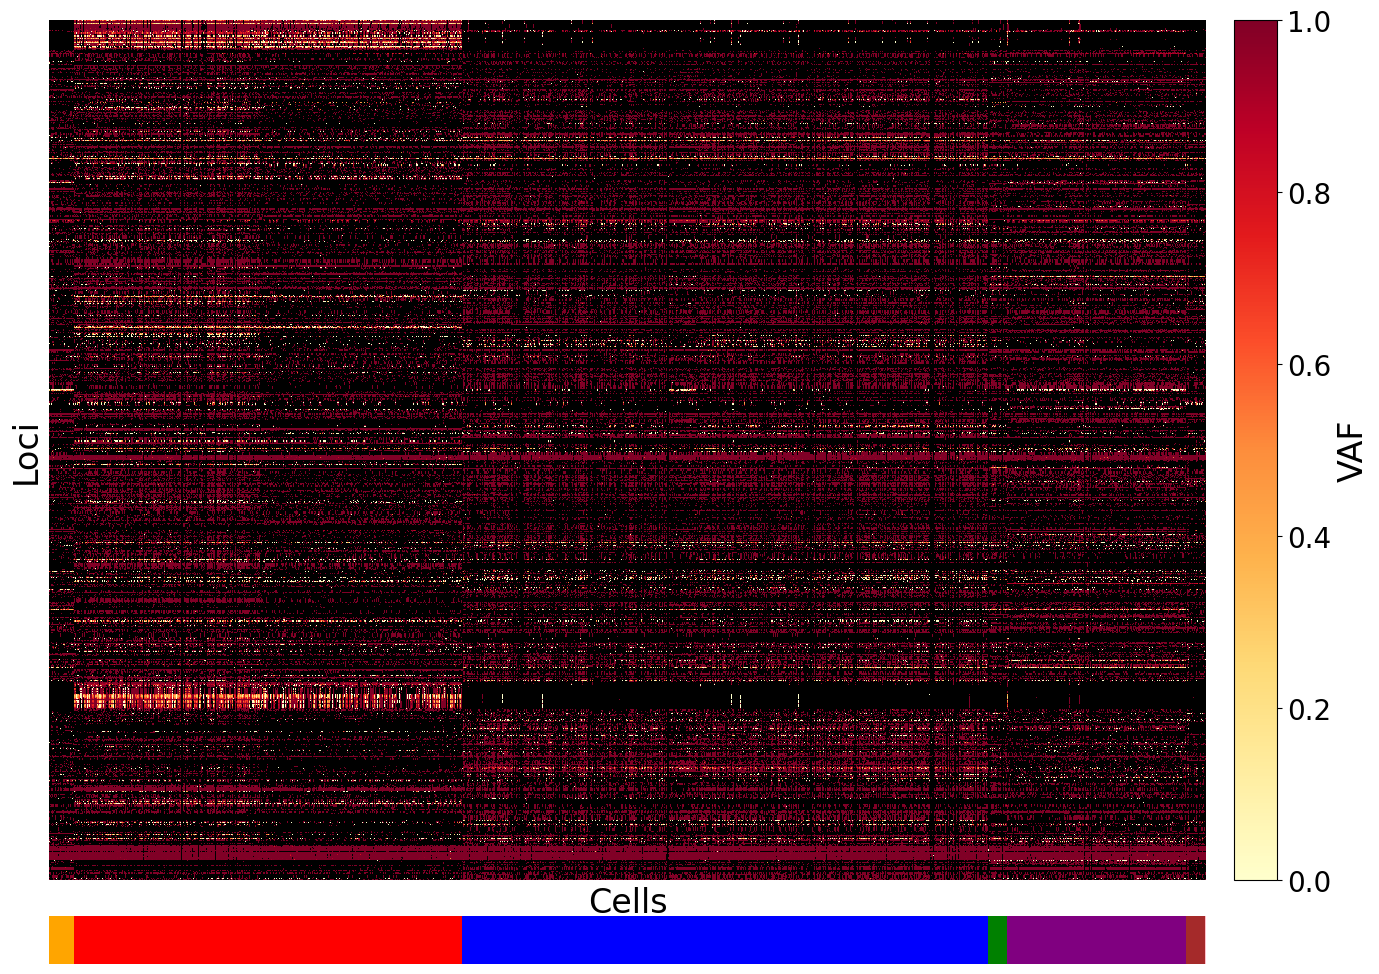

In [15]:
def plot_genotypes(model="sciterna", run_to_type=None, type_to_color=None):

    alt_df = pd.read_csv(r"..\data\input_data\BT_S2\alt.csv", index_col=0)
    ref_df = pd.read_csv(r"..\data\input_data\BT_S2\ref.csv", index_col=0)

    # Extract cell names
    cell_names = alt_df.index

    alt = alt_df.values.astype(int)
    ref = ref_df.values.astype(int)
    vaf = np.where((ref + alt) == 0, np.nan, alt / (ref + alt))

    # Order rows (cells) by cell type
    if run_to_type is None or type_to_color is None:
        raise ValueError("run_to_type and type_to_color must be provided as dictionaries.")

    cell_types = [run_to_type.get(cell, "unknown") for cell in cell_names]

    unique_types = sorted(
        set(cell_types),
        key=lambda x: list(type_to_color.keys()).index(x) if x in type_to_color else len(type_to_color)
    )

    # Order cell names by type
    ordered_cell_names = sorted(
        cell_names,
        key=lambda x: unique_types.index(run_to_type.get(x, "unknown"))
    )

    row_indices = [list(cell_names).index(name) for name in ordered_cell_names]
    vaf_ordered = vaf[row_indices, :]      # still row-sorted
    vaf_ordered = vaf_ordered.T

    row_colors = [type_to_color[run_to_type.get(cell, "unknown")] for cell in ordered_cell_names]

    # Plot VAF heatmap
    cmap = plt.cm.get_cmap("YlOrRd").copy()
    cmap.set_bad("black")

    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(2, 1, height_ratios=[0.94, 0.06], hspace=0.02)

    ax = fig.add_subplot(gs[0, 0])
    strip_ax = fig.add_subplot(gs[1, 0])

    hm = sns.heatmap(
        vaf_ordered,
        cmap=cmap,
        vmin=0.0,
        vmax=1.0,
        yticklabels=False,
        xticklabels=False,
        ax=ax,
        cbar=False
    )
    cbar = plt.colorbar(hm.collections[0], ax=ax, location="right", pad=0.02)
    cbar.set_label("VAF", fontsize=24)
    cbar.ax.tick_params(labelsize=20)

    for i, color in enumerate(row_colors):
        strip_ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color, linewidth=0))

    strip_ax.set_xlim(0, len(cell_names))
    strip_ax.set_ylim(0, 1)
    strip_ax.axis("off")

    ax_pos = ax.get_position()
    strip_ax.set_position([ax_pos.x0, ax_pos.y0 - 0.07, ax_pos.width, 0.04])

    ax.set_xlabel("Cells", fontsize=24)
    ax.set_ylabel("Loci", fontsize=24)
    plt.tight_layout()
    # plt.savefig(r"../data/results/BT_S2/sciterna/vaf.png", dpi=500)
    plt.show()

    return row_colors, ordered_cell_names

rcs, ocns = plot_genotypes(
    model="sciterna",
    run_to_type=run_to_type,
    type_to_color=type_to_color
)

In [16]:
def get_node_positions(dot):
    """Get x-coordinates of all nodes from Graphviz layout."""
    A = pgv.AGraph(string=dot.source if hasattr(dot, 'source') else dot)
    A.layout(prog="dot")
    positions = {}
    for node in A.nodes():
        name = node.get_name()
        if not name.isdigit():
            continue
        pos = node.attr.get('pos')
        if pos:
            x = float(pos.split(',')[0])
            positions[int(name)] = x
    return positions

def dfs_left_to_right(graph, root, n_cells, positions):

    leaf_order = []

    def dfs(node):
        children = graph.get(node, [])
        # Sort children by x-position
        children_sorted = sorted(children, key=lambda x: positions.get(x, float("inf")))
        if not children:
            if node < n_cells:  # leaf node condition
                leaf_order.append(node)
            return
        for child in children_sorted:
            dfs(child)

    dfs(root)
    return leaf_order

# Build adjacency list from parent vector
def build_adj_list(parent_vec):
    from collections import defaultdict
    adj = defaultdict(list)
    for child, parent in enumerate(parent_vec):
        if parent != -1:
            adj[parent].append(child)
    return adj

leaf_orders = {}

positions = get_node_positions(graph)
adj_list = build_adj_list(parent_vector)
root = np.where(np.array(parent_vector) == -1)[0][0]

leaf_orders[study_num] = dfs_left_to_right(adj_list, root, len(cell_names), positions)

<Figure size 4000x2000 with 0 Axes>

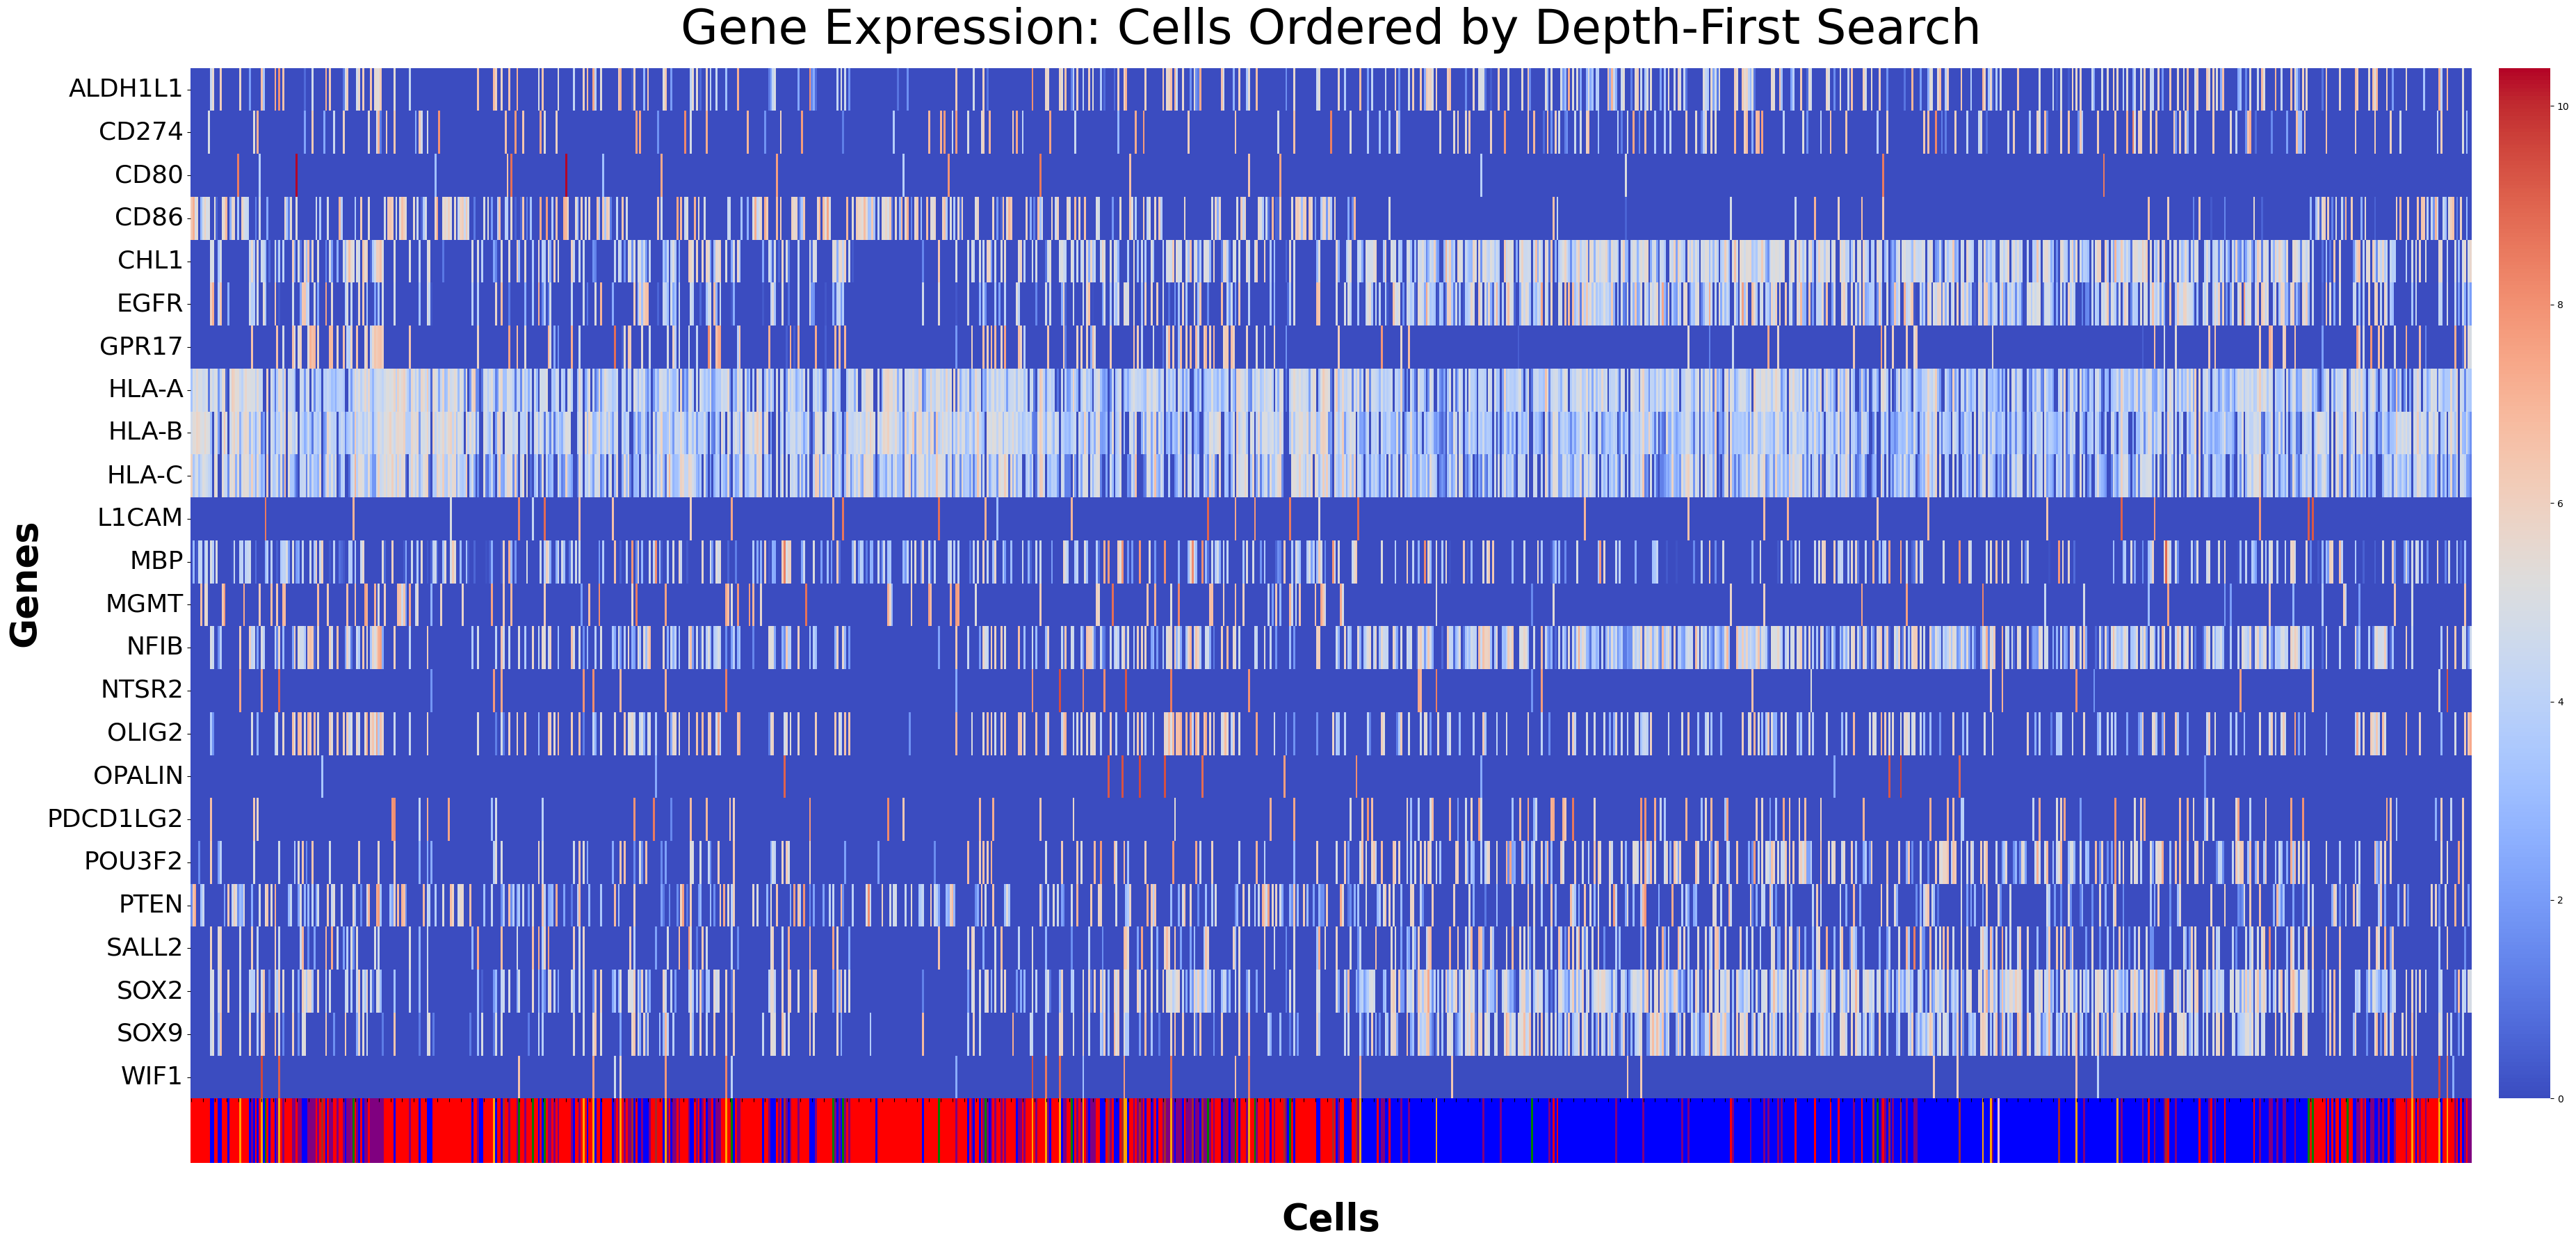

In [17]:
expression_counts = pd.read_csv(rf"../data/input_data/{study_num}/gene_expression_counts.csv", index_col=0)
normalized_counts = expression_counts.div(expression_counts.sum(axis=1), axis=0) * 1e5
expression_counts_scaled[study_num] = np.log1p(normalized_counts)

sorted_indices = leaf_orders[study_num]

plt.figure(figsize=(40, 20))

genes = [
    "EGFR", "CHL1", "SOX2", "SOX9", "POU3F2", "OLIG2", "SALL2", "NFIB",
    "MBP", "OPALIN", "GPR17", "L1CAM", "ALDH1L1", "WIF1", "NTSR2",
    "HLA-A", "HLA-B", "HLA-C", "CD274", "PDCD1LG2", "CD80", "CD86", "PTEN", "MGMT"
]

exp = expression_counts_scaled[study_num]
chosen_genes = exp[exp.index.isin(genes)]
sorted_df = chosen_genes.iloc[:, sorted_indices]

cells = sorted_df.columns.tolist()

col_colors = [type_to_color[run_to_type[cell]] for cell in cells]

plt.figure(figsize=(42, 18))
ax = sns.heatmap(sorted_df, cmap="coolwarm", cbar_kws={"pad": 0.01})

ax.set_xticklabels([])
ax.set_xlabel("Cells", fontsize=38, fontweight="bold", labelpad=100)

n_genes = sorted_df.shape[0]
from matplotlib.patches import Rectangle

n_cells = len(cells)
for i, color in enumerate(col_colors):
    ax.add_patch(
        Rectangle(
            (i, n_genes - 0.0),
            1, 1.5,         # width 1 cell, height
            color=color,
            transform=ax.transData,
            clip_on=False,
            linewidth=0
        )
    )

for tick_label in ax.get_yticklabels():
    tick_label.set_fontsize(26)
    tick_label.set_rotation(0)

plt.title("Gene Expression: Cells Ordered by Depth-First Search", fontsize=50, pad=25)
plt.ylabel("Genes", fontsize=38, fontweight="bold")

plt.tight_layout()
plt.savefig(rf"../data/results/figures/gene_expression_{study_num}.png", format="png", dpi=500)
plt.show()

Robinson Foulds distances between random pairs of bootstrapped trees

In [18]:
def to_newick(ct, node):
    if ct.isleaf(node):
        return f"{node}"
    children = ct.children(node)
    return "(" + ",".join(to_newick(ct, child) for child in children) + f"){node}"

dataset = "mm34" # mmm16, 50c500m
base_path = rf"../data/results/{dataset}/sciterna_bootstrapping"
n_bootstrap = 500
n_draws = 10000
n_round = 1

path_len_distances_bootstrap = []
rf_distances_bootstrap = []

path_len_distances_random = []
rf_distances_random = []

for t in range(n_draws):
    t1 = np.random.choice([r for r in range(n_bootstrap)])
    t2 = np.random.choice([r for r in range(n_bootstrap) if r != t1])

    sciterna_parent_vec1 = np.loadtxt(os.path.join(base_path, "sciterna_parent_vec", f"sciterna_parent_vec_{n_round}r{t1}.txt"), dtype=int)
    sciterna_parent_vec2 = np.loadtxt(os.path.join(base_path, "sciterna_parent_vec", f"sciterna_parent_vec_{n_round}r{t2}.txt"), dtype=int)

    n_c = int((len(sciterna_parent_vec1)+1)/2)

    ct_sciterna1 = CellTree(n_c, flipped_mutation_direction=True)
    ct_sciterna2 = CellTree(n_c, flipped_mutation_direction=True)

    ct_random1 = CellTree(n_c, flipped_mutation_direction=True)
    ct_random2 = CellTree(n_c, flipped_mutation_direction=True)
    ct_random1.rand_subtree()
    ct_random2.rand_subtree()

    ct_sciterna1.use_parent_vec(sciterna_parent_vec1)
    ct_sciterna2.use_parent_vec(sciterna_parent_vec2)

    path_len_distances_bootstrap.append(path_len_dist(ct_sciterna1, ct_sciterna2))
    path_len_distances_random.append(path_len_dist(ct_random1, ct_random2))

    newick1 = to_newick(ct_sciterna1, ct_sciterna1.main_root) + ";"
    newick2 = to_newick(ct_sciterna2, ct_sciterna2.main_root) + ";"
    taxa = dendropy.TaxonNamespace([str(i) for i in range(n_c)])
    tree1 = dendropy.Tree.get(data=newick1, schema="newick", taxon_namespace=taxa)
    tree2 = dendropy.Tree.get(data=newick2, schema="newick", taxon_namespace=taxa)
    rf_distances_bootstrap.append(treecompare.unweighted_robinson_foulds_distance(tree1, tree2))#/(2*(n_c-3)))

    newick_random1 = to_newick(ct_random1, ct_random1.main_root) + ";"
    newick_random2 = to_newick(ct_random2, ct_random2.main_root) + ";"
    tree_random1 = dendropy.Tree.get(data=newick_random1, schema="newick", taxon_namespace=taxa)
    tree_random2 = dendropy.Tree.get(data=newick_random2, schema="newick", taxon_namespace=taxa)
    rf_distances_random.append(treecompare.unweighted_robinson_foulds_distance(tree_random1, tree_random2)) #/(2*(n_c-3)))

In [ ]:
def plot_comparative_histograms(data1, xlabel, ylabel, label1, alpha=0.6):
    data1 = np.array(data1)
    unique, counts = np.unique(data1, return_counts=True)
    plt.bar(unique, counts, alpha=alpha, label=label1)

    plt.grid(False)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlim(data1.max()-40, data1.max()+1)
    plt.tight_layout()
    plt.savefig(rf"../data/results/figures/{xlabel}_{dataset}_comparison.svg")
    plt.show()


# plot_comparative_histograms(path_len_distances_bootstrap, "Path Length", "Frequency", "Bootstrap)
plot_comparative_histograms(rf_distances_bootstrap, "Robinson-Foulds Distance", "Number of Samples", "Bootstrap")